<a href="https://colab.research.google.com/github/sherinshaban/Speech-Emotion-Recognition/blob/main/Analysis_Speech_Dataset__RAVDESS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch numpy pandas librosa scikit-learn joblib
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import librosa
import os
import zipfile
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from google.colab import drive
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
import os
import zipfile
import shutil
print("Cleaning the connected folder...")

try:
    if os.path.exists('/content/gdrive'):
        shutil.rmtree('/content/gdrive')
        print("content/gdrive was cleared successfully.")
except Exception as e:
    print(f"Failed to clear the folder/content/gdrive: {e}")


drive.mount('/content/gdrive', force_remount=True)
print("Google Drive connected successfully.")




ZIP_PATH = '/content/gdrive/MyDrive/Audio_Speech_Actors_01-24.zip'


TARGET_DIR = '/content/gdrive/MyDrive/RAVDESS_PROCESSED_DATA'


os.makedirs(TARGET_DIR, exist_ok=True)

print(f"The file has been extracted from {ZIP_PATH} to {TARGET_DIR}...")

try:
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(TARGET_DIR)
    print("Extraction completed successfully.")

    RAVDESS_AUDIO_DIR = os.path.join(TARGET_DIR, 'Audio_Speech_Actors_01-24')
    print("Final audio data path:", RAVDESS_AUDIO_DIR)

except FileNotFoundError:
    print(f"Error: ZIP file not found at the specified path: {ZIP_PATH}")
    raise
except Exception as e:
    print(f"Error occurred during extraction: {e}")
    raise

Cleaning the connected folder...
Mounted at /content/gdrive
Google Drive connected successfully.
The file has been extracted from /content/gdrive/MyDrive/Audio_Speech_Actors_01-24.zip to /content/gdrive/MyDrive/RAVDESS_PROCESSED_DATA...
Extraction completed successfully.
Final audio data path: /content/gdrive/MyDrive/RAVDESS_PROCESSED_DATA/Audio_Speech_Actors_01-24


Searching for sample audio files...
Found 6 samples. Generating Spectrograms...


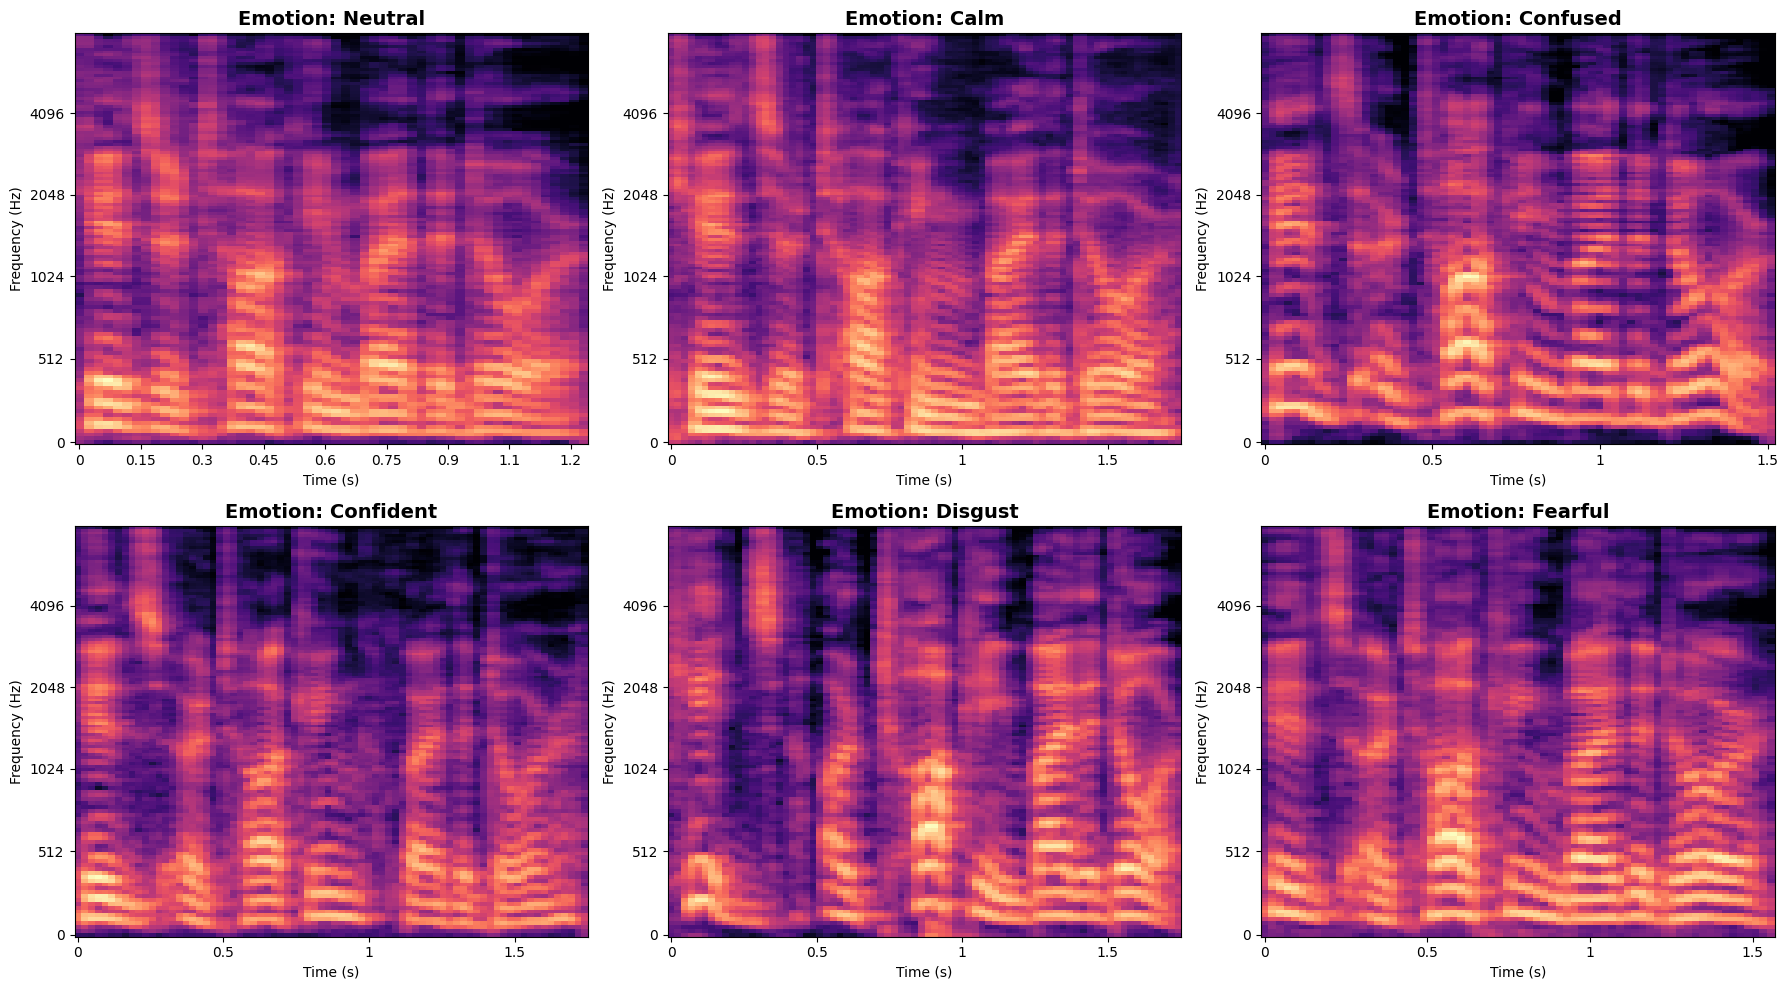

In [ ]:
# -*- coding: utf-8 -*-
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import os

SR = 22050
N_MELS = 128

try:
    BASE_DIR = RAVDESS_AUDIO_DIR
except NameError:

    BASE_DIR = '/content/gdrive/MyDrive/RAVDESS_PROCESSED_DATA/Audio_Speech_Actors_01-24'
    print("Warning: RAVDESS_AUDIO_DIR not found. Using default path:", BASE_DIR)

EMOTIONS_TO_VISUALIZE = {
    '01': 'Neutral',
    '02': 'Calm',
    '03': 'Confused',
    '04': 'Confident',
    '05': 'Disgust',
    '06': 'Fearful'
}

# Helper function to find one audio file per emotion
def find_sample_files(base_dir, emotion_codes):
    sample_files = {}
    if not os.path.exists(base_dir):
        return sample_files

    actors = sorted([d for d in os.listdir(base_dir) if d.startswith('Actor_')])

    for actor in actors:
        actor_path = os.path.join(base_dir, actor)
        if not os.path.isdir(actor_path): continue

        for filename in os.listdir(actor_path):
            if not filename.endswith('.wav'): continue
            parts = filename.split('-')
            if len(parts) < 3: continue
            emo_code = parts[2]

            # If we need this emotion and haven't found a sample yet
            if emo_code in emotion_codes and emo_code not in sample_files:
                sample_files[emo_code] = os.path.join(actor_path, filename)

            # Stop if we found samples for all emotions
            if len(sample_files) == len(emotion_codes):
                return sample_files
    return sample_files

print("Searching for sample audio files...")
samples = find_sample_files(BASE_DIR, EMOTIONS_TO_VISUALIZE)

if not samples:
    print(f"Error: No files found in directory: {BASE_DIR}")
    print("Please check if the dataset is unzipped correctly.")
else:
    print(f"Found {len(samples)} samples. Generating Spectrograms...")

    # Setup the plot figure (2 rows, 3 columns)
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
    axes = axes.flatten()

    for i, (code, emotion_label) in enumerate(EMOTIONS_TO_VISUALIZE.items()):
        if code in samples:
            file_path = samples[code]
            try:
                # 1. Load Audio
                y, sr = librosa.load(file_path, sr=SR)
                # Trim silence (same as preprocessing)
                y, _ = librosa.effects.trim(y, top_db=20)

                # 2. Compute Mel-Spectrogram
                S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS)
                S_dB = librosa.power_to_db(S, ref=np.max)

                # 3. Plot
                ax = axes[i]
                img = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr, fmax=8000, ax=ax)
                ax.set_title(f"Emotion: {emotion_label}", fontsize=14, fontweight='bold')
                ax.set_xlabel('Time (s)')
                ax.set_ylabel('Frequency (Hz)')

            except Exception as e:
                print(f"Error processing emotion {emotion_label}: {e}")
                axes[i].text(0.5, 0.5, "Error Loading", ha='center')

    plt.tight_layout()
    plt.show()

Searching for an example 'Neutral' file...
Found sample: 03-01-01-01-01-01-01.wav
Generating Waveform vs. Spectrogram comparison...


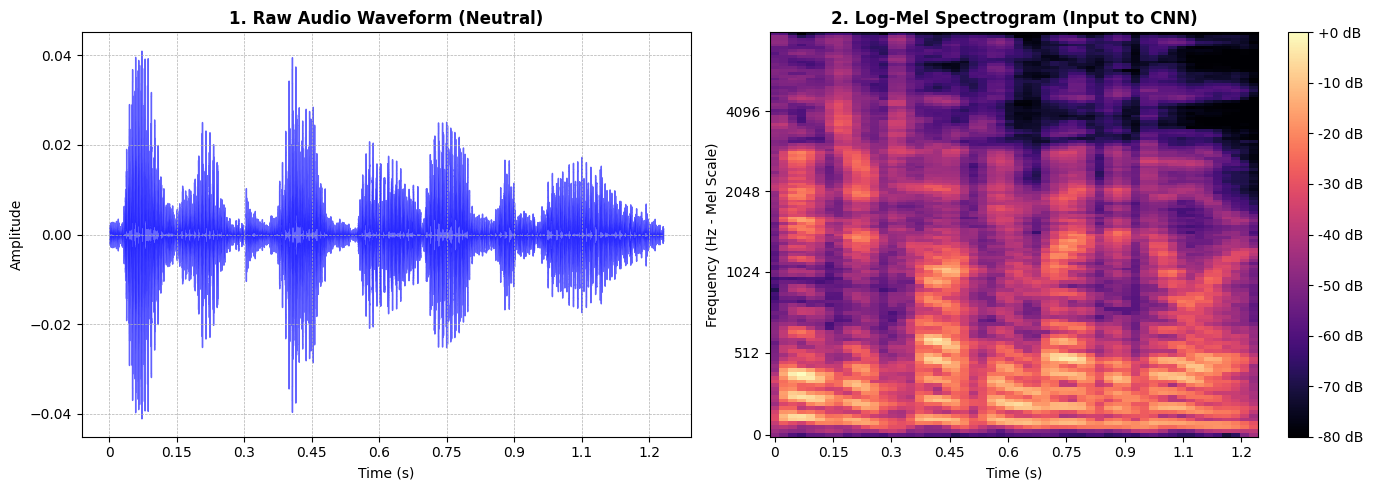

In [ ]:
# -*- coding: utf-8 -*-
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import os

SR = 22050
N_MELS = 128


try:
    BASE_DIR = RAVDESS_AUDIO_DIR
except NameError:
    BASE_DIR = '/content/gdrive/MyDrive/RAVDESS_PROCESSED_DATA/Audio_Speech_Actors_01-24'
    print("Warning: RAVDESS_AUDIO_DIR not found. Using default path:", BASE_DIR)

EXAMPLE_EMOTION_CODE = '01'
EXAMPLE_EMOTION_LABEL = 'Neutral'

def find_single_sample(base_dir, target_code):
    if not os.path.exists(base_dir): return None
    actors = sorted([d for d in os.listdir(base_dir) if d.startswith('Actor_')])
    for actor in actors:
        actor_path = os.path.join(base_dir, actor)
        if not os.path.isdir(actor_path): continue
        for filename in os.listdir(actor_path):
            if filename.endswith('.wav') and filename.split('-')[2] == target_code:
                return os.path.join(actor_path, filename)
    return None

print(f"Searching for an example '{EXAMPLE_EMOTION_LABEL}' file...")
sample_file = find_single_sample(BASE_DIR, EXAMPLE_EMOTION_CODE)

if not sample_file:
    print(f"Error: Could not find a sample file for emotion code {EXAMPLE_EMOTION_CODE}")
else:
    print(f"Found sample: {os.path.basename(sample_file)}")
    print("Generating Waveform vs. Spectrogram comparison...")

    try:

        y, sr = librosa.load(sample_file, sr=SR)
        y_trimmed, _ = librosa.effects.trim(y, top_db=20)

        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

        librosa.display.waveshow(y_trimmed, sr=sr, ax=ax[0], color='blue', alpha=0.6)
        ax[0].set_title(f"1. Raw Audio Waveform ({EXAMPLE_EMOTION_LABEL})", fontsize=12, fontweight='bold')
        ax[0].set_xlabel("Time (s)")
        ax[0].set_ylabel("Amplitude")
        ax[0].grid(True, which='both', linestyle='--', linewidth=0.5)


        S = librosa.feature.melspectrogram(y=y_trimmed, sr=sr, n_mels=N_MELS)
        S_dB = librosa.power_to_db(S, ref=np.max)


        img = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr, fmax=8000, ax=ax[1], cmap='magma')
        ax[1].set_title(f"2. Log-Mel Spectrogram (Input to CNN)", fontsize=12, fontweight='bold')
        ax[1].set_xlabel("Time (s)")
        ax[1].set_ylabel("Frequency (Hz - Mel Scale)")
        fig.colorbar(img, ax=ax[1], format='%+2.0f dB')

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error processing file: {e}")

In [ ]:
import os
TARGET_DIR = '/content/gdrive/MyDrive/RAVDESS_PROCESSED_DATA'
contents = os.listdir(TARGET_DIR)

if 'Audio_Speech_Actors_01-24' in contents:
    RAVDESS_AUDIO_DIR = os.path.join(TARGET_DIR, 'Audio_Speech_Actors_01-24')
    print("Hypothesis 1: Subfolder found.")
elif any(item.startswith('Actor_') for item in contents):
    RAVDESS_AUDIO_DIR = TARGET_DIR
    print("Hypothesis 2: Actor files found directly.")
else:
    print("Error: Actor files (Actor_XX) were not found in any of the expected paths.")
    RAVDESS_AUDIO_DIR = TARGET_DIR

print("The path that Cell 3 will use is:", RAVDESS_AUDIO_DIR)

Hypothesis 2: Actor files found directly.
The path that Cell 3 will use is: /content/gdrive/MyDrive/RAVDESS_PROCESSED_DATA


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import librosa
import os

EMOTIONS = {
    '03': 'Confused',
    '04': 'Confident',
    '05': 'Disgust',
    '06': 'Fearful',
    '01': 'Neutral',
    '02': 'Calm'
}
SAMPLES_PER_CLASS = 30

def apply_feature_extraction(y, sr, max_pad_len=174):
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

    current_len = log_mel_spectrogram.shape[1]

    if current_len > max_pad_len:
        padded_feature = log_mel_spectrogram[:, :max_pad_len]
    elif current_len < max_pad_len:
        pad_width = max_pad_len - current_len
        padded_feature = np.pad(log_mel_spectrogram, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        padded_feature = log_mel_spectrogram

    return padded_feature

def extract_features_and_augment(directory, emotions, samples_per_class):
    features = []
    labels = []
    sample_counts = {emotion: 0 for emotion in emotions.values()}
    SR = 22050
    MAX_PAD_LEN = 174

    print("Starting feature extraction and applying Data Augmentation (x6)…")

    for actor in sorted(os.listdir(directory)):
        actor_path = os.path.join(directory, actor)
        if os.path.isdir(actor_path):
            for filename in sorted(os.listdir(actor_path)):
                emotion_code = filename.split('-')[2]

                if emotion_code in emotions:
                    emotion = emotions[emotion_code]

                    if sample_counts[emotion] < samples_per_class:
                        file_path = os.path.join(actor_path, filename)

                        try:
                            y_original, sr = librosa.load(file_path, sr=SR)

                            augmented_samples = [
                                y_original,
                                y_original + 0.005 * np.random.normal(0, 1, y_original.shape),
                                librosa.effects.pitch_shift(y_original, sr=sr, n_steps=0.7),
                                librosa.effects.pitch_shift(y_original, sr=sr, n_steps=-0.7),
                                librosa.effects.time_stretch(y_original, rate=1.1),
                                librosa.effects.time_stretch(y_original, rate=0.9)
                            ]

                            for y_aug in augmented_samples:
                                features.append(apply_feature_extraction(y_aug, sr, MAX_PAD_LEN))
                                labels.append(emotion)

                            sample_counts[emotion] += 1

                        except Exception as e:
                            pass

                if all(count >= samples_per_class for count in sample_counts.values()):
                    break
        if all(count >= samples_per_class for count in sample_counts.values()):
            break

    print("--- Feature extraction completed. ---")

    return np.array(features), np.array(labels)
X_features, y_labels = extract_features_and_augment(RAVDESS_AUDIO_DIR, EMOTIONS, SAMPLES_PER_CLASS)

le = LabelEncoder()
y_encoded = le.fit_transform(y_labels)

X_features_tensor = torch.tensor(X_features, dtype=torch.float32).unsqueeze(1)
y_encoded_tensor = torch.tensor(y_encoded, dtype=torch.long)

X_temp_train_val, X_test, y_temp_train_val, y_test = train_test_split(
    X_features_tensor, y_encoded_tensor, test_size=0.20, random_state=42, stratify=y_encoded_tensor
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp_train_val, y_temp_train_val, test_size=0.125, random_state=42, stratify=y_temp_train_val
)

print(f"\nTotal samples: {len(X_features_tensor)}")
print(f"Training set size: {len(X_train)} samples (about 70%)")
print(f"Validation set size: {len(X_val)} samples (about 10%)")
print(f"Final test set size (Hold-out Test): {len(X_test)} samples (about 20%)")

class AudioDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = AudioDataset(X_train, y_train)
val_dataset = AudioDataset(X_val, y_val)
test_dataset = AudioDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

Starting feature extraction and applying Data Augmentation (x6)…
--- Feature extraction completed. ---

Total samples: 1080
Training set size: 756 samples (about 70%)
Validation set size: 108 samples (about 10%)
Final test set size (Hold-out Test): 216 samples (about 20%)


Generating Augmentation Visualization for: 03-01-01-01-01-01-01.wav


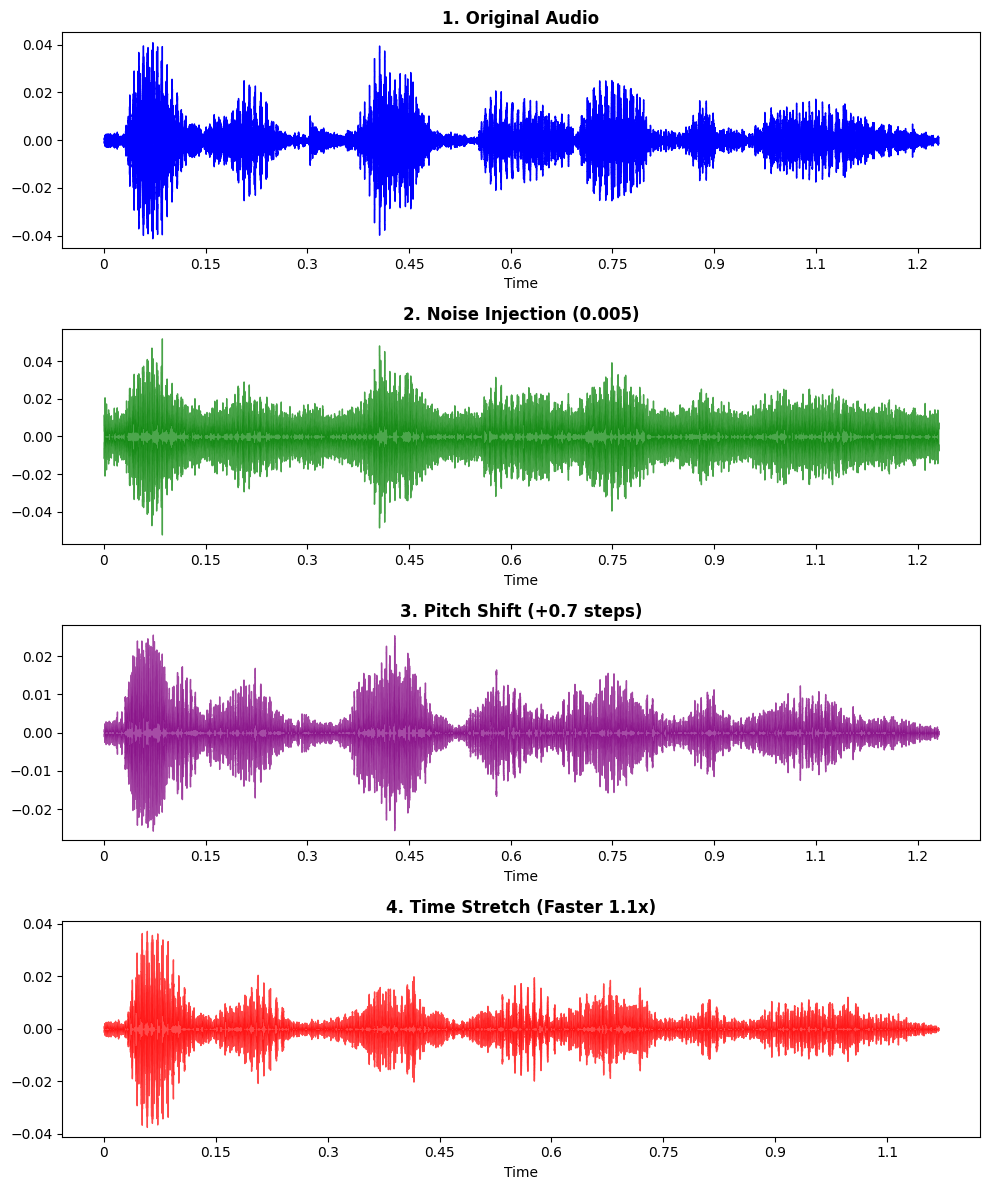

In [ ]:
# -*- coding: utf-8 -*-
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import os

SR = 22050

if 'sample_file' not in locals() or sample_file is None:

    print("Please define 'sample_file' path first (run previous visualization code).")
else:
    print(f"Generating Augmentation Visualization for: {os.path.basename(sample_file)}")

    y, sr = librosa.load(sample_file, sr=SR)
    y, _ = librosa.effects.trim(y, top_db=20)

    y_noise = y + 0.005 * np.random.normal(0, 1, y.shape)
    # 2. Pitch Shift (+0.7) - Higher
    y_pitch_high = librosa.effects.pitch_shift(y, sr=sr, n_steps=0.7)
    # 3. Time Stretch (Fast 1.1)
    y_speed_fast = librosa.effects.time_stretch(y, rate=1.1)

    fig, axes = plt.subplots(4, 1, figsize=(10, 12), sharex=False)

    # Original
    librosa.display.waveshow(y, sr=sr, ax=axes[0], color='blue')
    axes[0].set_title("1. Original Audio", fontweight='bold')

    # Noise
    librosa.display.waveshow(y_noise, sr=sr, ax=axes[1], color='green', alpha=0.7)
    axes[1].set_title("2. Noise Injection (0.005)", fontweight='bold')

    # Pitch
    librosa.display.waveshow(y_pitch_high, sr=sr, ax=axes[2], color='purple', alpha=0.7)
    axes[2].set_title("3. Pitch Shift (+0.7 steps)", fontweight='bold')

    # Speed (Note: x-axis time will change)
    librosa.display.waveshow(y_speed_fast, sr=sr, ax=axes[3], color='red', alpha=0.7)
    axes[3].set_title("4. Time Stretch (Faster 1.1x)", fontweight='bold')

    plt.tight_layout()
    plt.show()

In [ ]:
import torch
import torch.nn as nn
NUM_CLASSES = len(EMOTIONS)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
INPUT_CHANNELS = 1

class DeeperCNN(nn.Module):
    def __init__(self, num_classes):
        super(DeeperCNN, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=INPUT_CHANNELS, out_channels=32, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        )

        self.dropout = nn.Dropout(p=0.3)
        self.fc1 = nn.Linear(128 * 16 * 21, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)

        x = self.dropout(x)

        x = nn.ReLU()(self.fc1(x))
        x = self.fc2(x)
        return x

model = DeeperCNN(NUM_CLASSES).to(DEVICE)
print("A deeper CNN model has been built and is ready for training .")

A deeper CNN model has been built and is ready for training .


In [ ]:
import torch.optim as optim
from sklearn.metrics import classification_report
import numpy as np

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
NUM_EPOCHS = 30

def calculate_accuracy(loader, model, device):
    """Function to calculate accuracy for any dataset (training, validation, test)"""
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

print(f"\n Starting CNN model training on a(70/10/20) split ...")

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    train_accuracy = calculate_accuracy(train_loader, model, DEVICE)
    val_accuracy = calculate_accuracy(val_loader, model, DEVICE)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Train Loss: {running_loss / len(train_dataset):.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")

print("\n---Training completed. Starting final evaluation . ---")

test_accuracy = calculate_accuracy(test_loader, model, DEVICE)

model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_labels_names = le.inverse_transform(all_labels)
test_preds_names = le.inverse_transform(all_preds)

print("\n========== Final classification report on the isolated test sample (Hold-out Set) ==========")
print(f"Final accuracy on the test sample (Test Accuracy): {test_accuracy:.4f}")
print(classification_report(test_labels_names, test_preds_names, target_names=le.classes_))
print("==================================================")


 Starting CNN model training on a(70/10/20) split ...
Epoch 1/30, Train Loss: 22.5934, Train Accuracy: 0.1799, Validation Accuracy: 0.1759
Epoch 2/30, Train Loss: 7.8333, Train Accuracy: 0.1786, Validation Accuracy: 0.1759
Epoch 3/30, Train Loss: 3.1371, Train Accuracy: 0.2593, Validation Accuracy: 0.3241
Epoch 4/30, Train Loss: 1.9084, Train Accuracy: 0.2209, Validation Accuracy: 0.2222
Epoch 5/30, Train Loss: 1.6621, Train Accuracy: 0.2884, Validation Accuracy: 0.2778
Epoch 6/30, Train Loss: 1.4677, Train Accuracy: 0.5040, Validation Accuracy: 0.4444
Epoch 7/30, Train Loss: 1.3418, Train Accuracy: 0.5384, Validation Accuracy: 0.4352
Epoch 8/30, Train Loss: 1.2735, Train Accuracy: 0.5344, Validation Accuracy: 0.5370
Epoch 9/30, Train Loss: 1.1685, Train Accuracy: 0.6098, Validation Accuracy: 0.5741
Epoch 10/30, Train Loss: 1.1019, Train Accuracy: 0.6587, Validation Accuracy: 0.5648
Epoch 11/30, Train Loss: 1.0293, Train Accuracy: 0.6640, Validation Accuracy: 0.5833
Epoch 12/30, Train

In [ ]:
import torch
import joblib

MODEL_SAVE_PATH = '/content/gdrive/MyDrive/ser_cnn_model.pth'
torch.save(model.state_dict(), MODEL_SAVE_PATH)
print(f"CNN model weights have been successfully saved to: {MODEL_SAVE_PATH}")

LE_SAVE_PATH = '/content/gdrive/MyDrive/label_encoder.pkl'
joblib.dump(le, LE_SAVE_PATH)
print(f"Label Encoder has been successfully saved to: {LE_SAVE_PATH}")

CNN model weights have been successfully saved to: /content/gdrive/MyDrive/ser_cnn_model.pth
Label Encoder has been successfully saved to: /content/gdrive/MyDrive/label_encoder.pkl


In [ ]:
import torch
import torch.nn as nn
import joblib
import librosa
import numpy as np

MAX_PAD_LEN = 174
SR = 22050
NUM_CLASSES = 6
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class DeeperCNN(nn.Module):
    def __init__(self, num_classes):
        super(DeeperCNN, self).__init__()

        self.conv1 = nn.Sequential(nn.Conv2d(1, 32, kernel_size=(3, 3), padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(kernel_size=(2, 2), stride=2))
        self.conv2 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(kernel_size=(2, 2), stride=2))
        self.conv3 = nn.Sequential(nn.Conv2d(64, 128, kernel_size=(3, 3), padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(kernel_size=(2, 2), stride=2))
        self.dropout = nn.Dropout(p=0.3)
        self.fc1 = nn.Linear(128 * 16 * 21, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = nn.ReLU()(self.fc1(x))
        x = self.fc2(x)
        return x

MODEL_PATH = '/content/gdrive/MyDrive/ser_cnn_model.pth'
LE_PATH = '/content/gdrive/MyDrive/label_encoder.pkl'

model = DeeperCNN(NUM_CLASSES).to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()
le = joblib.load(LE_PATH)
print("The model and Label Encoder have been successfully loaded.")

def predict_emotion(audio_file_path):
    """Takes an audio file path and returns the prediction and probabilities."""
    try:
        y, sr = librosa.load(audio_file_path, sr=SR)
        y_trimmed, _ = librosa.effects.trim(y, top_db=20)
        mel_spectrogram = librosa.feature.melspectrogram(y=y_trimmed, sr=sr, n_mels=128)
        log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

        current_len = log_mel_spectrogram.shape[1]
        if current_len > MAX_PAD_LEN:
            feature = log_mel_spectrogram[:, :MAX_PAD_LEN]
        elif current_len < MAX_PAD_LEN:
            pad_width = MAX_PAD_LEN - current_len
            feature = np.pad(log_mel_spectrogram, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            feature = log_mel_spectrogram

        feature_tensor = torch.tensor(feature, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(DEVICE)

        with torch.no_grad():
            output = model(feature_tensor)
            probabilities = torch.softmax(output, dim=1).cpu().numpy().flatten()
            predicted_index = torch.argmax(output, dim=1).cpu().item()

        emotion = le.inverse_transform([predicted_index])[0]

        prob_dict = {le.classes_[i]: float(probabilities[i]) for i in range(NUM_CLASSES)}

        return {
            "predicted_emotion": emotion,
            "probabilities": prob_dict
        }

    except Exception as e:
        return {"error": f"An error occurred during processing : {e}"}

example_test_path ='/content/gdrive/MyDrive/RAVDESS_PROCESSED_DATA/Actor_02/03-01-01-01-01-01-02.wav'

prediction_result = predict_emotion(example_test_path)

print("\n========== Prediction result (API Test) ==========")
print(f"File: {example_test_path.split('/')[-1]}")
if "error" in prediction_result:
    print(prediction_result["error"])
else:
    print(f"Predicted emotions: **{prediction_result['predicted_emotion']}**")
    print("Probabilities:")
    for emo, prob in prediction_result['probabilities'].items():
        print(f"- {emo}: {prob:.4f}")
print("==============================================")

The model and Label Encoder have been successfully loaded.

========== Prediction result (API Test) ==========
File: 03-01-01-01-01-01-02.wav
Predicted emotions: **Calm**
Probabilities:
- Calm: 0.9734
- Confident: 0.0002
- Confused: 0.0010
- Disgust: 0.0131
- Fearful: 0.0000
- Neutral: 0.0123


Generating Confusion Matrix...


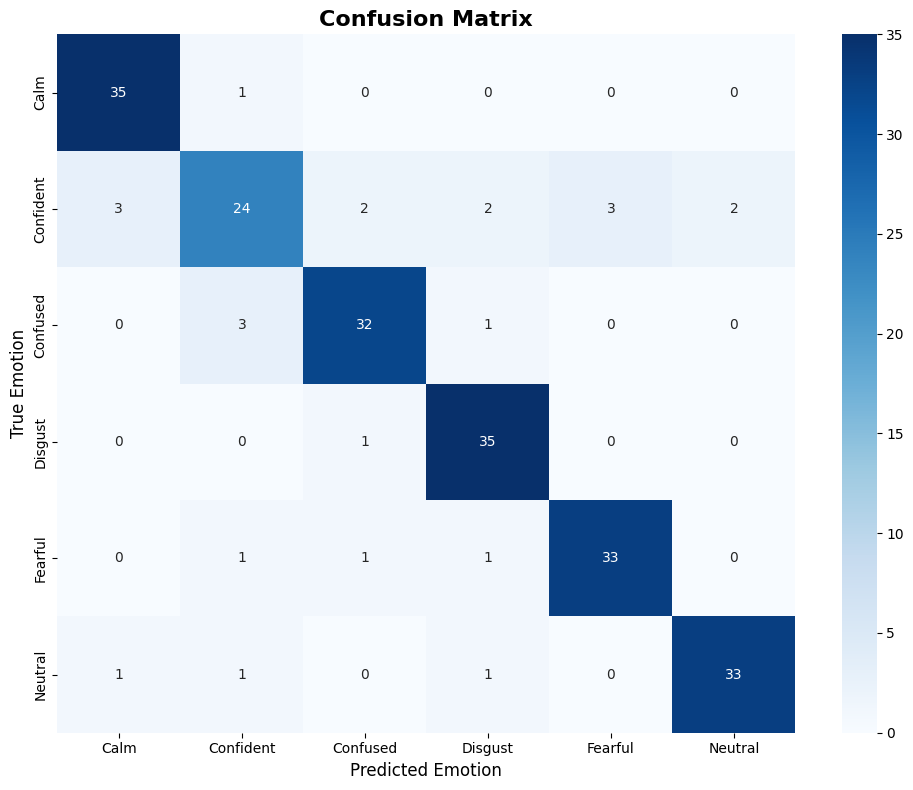


Final Test Accuracy: 88.89%


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
import torch


model.eval()
y_true = []
y_pred = []

print("Generating Confusion Matrix...")

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

emotion_names = le.classes_

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=emotion_names,
            yticklabels=emotion_names)

plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Emotion', fontsize=12)
plt.ylabel('True Emotion', fontsize=12)
plt.tight_layout()
plt.show()

accuracy = np.sum(np.array(y_true) == np.array(y_pred)) / len(y_true)
print(f"\nFinal Test Accuracy: {accuracy*100:.2f}%")

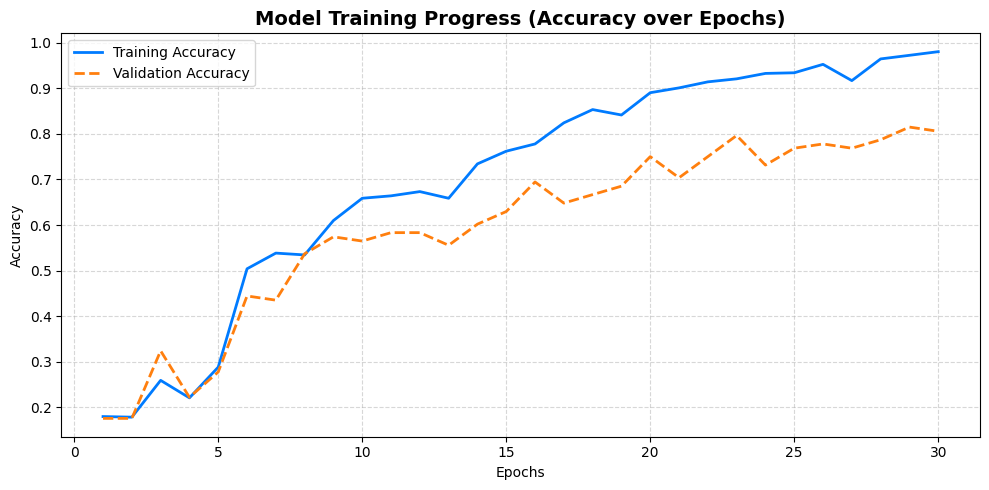

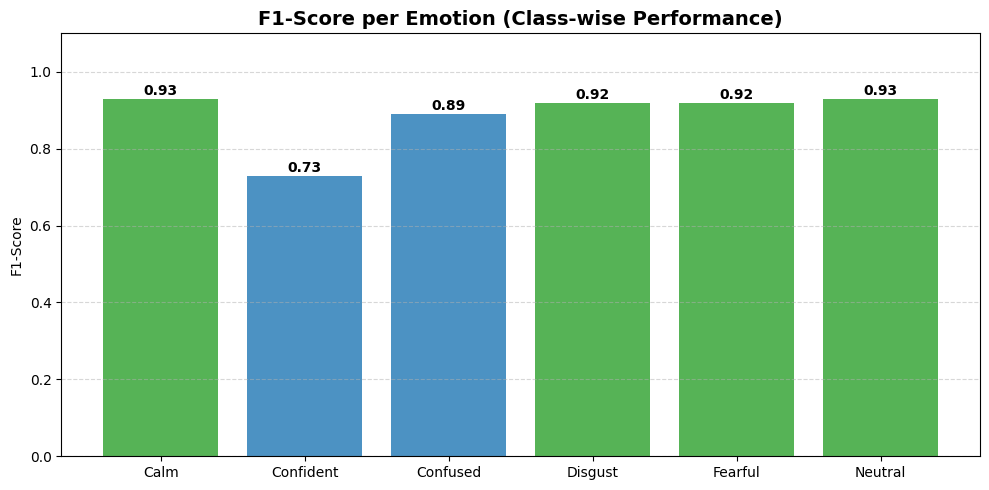

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

epochs = range(1, 31)
train_acc = [0.1799, 0.1786, 0.2593, 0.2209, 0.2884, 0.5040, 0.5384, 0.5344, 0.6098, 0.6587,
             0.6640, 0.6733, 0.6587, 0.7341, 0.7619, 0.7778, 0.8241, 0.8532, 0.8413, 0.8902,
             0.9008, 0.9140, 0.9206, 0.9325, 0.9339, 0.9524, 0.9167, 0.9643, 0.9722, 0.9802]

val_acc = [0.1759, 0.1759, 0.3241, 0.2222, 0.2778, 0.4444, 0.4352, 0.5370, 0.5741, 0.5648,
           0.5833, 0.5833, 0.5556, 0.6019, 0.6296, 0.6944, 0.6481, 0.6667, 0.6852, 0.7500,
           0.7037, 0.7500, 0.7963, 0.7315, 0.7685, 0.7778, 0.7685, 0.7870, 0.8148, 0.8056]

emotions = ['Calm', 'Confident', 'Confused', 'Disgust', 'Fearful', 'Neutral']
f1_scores = [0.93, 0.73, 0.89, 0.92, 0.92, 0.93]

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc, label='Training Accuracy', color='#007bff', linewidth=2)
plt.plot(epochs, val_acc, label='Validation Accuracy', color='#ff7f0e', linewidth=2, linestyle='--')
plt.title('Model Training Progress (Accuracy over Epochs)', fontsize=14, fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('accuracy_curve.png')
plt.show()

plt.figure(figsize=(10, 5))
colors = ['#2ca02c' if x > 0.9 else '#1f77b4' for x in f1_scores]
bars = plt.bar(emotions, f1_scores, color=colors, alpha=0.8)


for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{yval:.2f}", ha='center', fontweight='bold')

plt.title('F1-Score per Emotion (Class-wise Performance)', fontsize=14, fontweight='bold')
plt.ylabel('F1-Score')
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('emotion_performance.png')
plt.show()